This code
1. Loads the cancer dataset, available at: https://hastie.su.domains/ElemStatLearn/datasets/prostate.data
2. Standardizes the training data (not the targets)
3. Transforms the testing data in the same manner by using the means and standard deviations of the training data
4. Performs Ordinary Least Squares on training data
5. Tests the average error of the OLS model on the test data

In [1]:
import torch
torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt


We want to perform sparse linear regression on the prostate cancer dataset using Ridge, LASSO, and ElasticNet and compare it with LASSO++
https://hastie.su.domains/ElemStatLearn/datasets/prostate.data

In [2]:
import pandas as pd
# reading csv files
data =  pd.read_csv('prostate.data', sep="	")
data
# # reading tsv files
# data = pd.read_csv('prostate.data', sep="\t")
# print(data)

,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
92,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


n=97 observations, 67 training, 30 test
p=8 predictors
y = lpsa (response) 96 * 1 
X = 96 * 8
beta = 8 * 1 (coefficients)
y = X * beta

Data needs to be split. Normalize and standardize (columns) using the training data only, extend the stored parameters to normalize and standardize the test data too

In [3]:
# Convert data to doubles
data_cols = ['age', 'gleason', 'lbph', 'lcavol', 'lcp','lweight', 'pgg45', 'svi']
data[data_cols] = data[data_cols].astype('double', copy=True, errors='raise')

grouped = data.groupby(data.train)
pan_train_data = grouped.get_group("T")
pan_test_data = grouped.get_group("F")


# The data needs to be normalized
means = pan_train_data[data_cols].mean()
variances = pan_train_data[data_cols].std(ddof=0)

pan_train_data[data_cols] = (pan_train_data[data_cols]-means)/variances
pan_test_data[data_cols] = (pan_test_data[data_cols]-means)/variances



/var/folders/y3/t7nmdh795s52pz2bygv2tzj00000gn/T/ipykernel_24389/1560018052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pan_train_data[data_cols] = (pan_train_data[data_cols]-means)/variances
/var/folders/y3/t7nmdh795s52pz2bygv2tzj00000gn/T/ipykernel_24389/1560018052.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pan_test_data[data_cols] = (pan_test_data[data_cols]-means)/variances


In [4]:
data.dtypes

Unnamed: 0      int64
lcavol        float64
lweight       float64
age           float64
lbph          float64
svi           float64
lcp           float64
gleason       float64
pgg45         float64
lpsa          float64
train          object
dtype: object

In [5]:
pan_train_data

,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-1.535180,-1.810979,-1.980425,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,-0.430783,T
1,2,-1.871221,-0.647911,-0.906025,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,-0.162519,T
2,3,-1.479237,-1.976330,1.242777,-1.003472,-0.537086,-0.843084,0.381857,-0.215549,-0.162519,T
3,4,-2.041272,-0.725785,-0.906025,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,-0.162519,T
4,5,-0.455756,-0.409561,-0.368824,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
90,91,1.567362,1.005663,0.436976,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,4.029806,T
91,92,0.988753,0.108784,-0.503124,0.878806,1.861899,-0.843084,0.381857,-0.387475,4.129551,T
92,93,1.229869,0.529116,0.436976,-1.003472,1.861899,1.104813,0.381857,1.159859,4.385147,T
93,94,2.033202,0.572482,-2.786226,-1.003472,1.861899,1.714274,0.381857,0.472155,4.684443,T


In [6]:
print(pan_train_data[data_cols].mean())
print(pan_train_data[data_cols].var(ddof=0))

age       -8.086401e-16
gleason    6.114512e-16
lbph       6.628197e-17
lcavol     3.314099e-18
lcp        3.380381e-16
lweight   -1.932119e-15
pgg45      6.628197e-17
svi       -2.717561e-16
dtype: float64
age        1.0
gleason    1.0
lbph       1.0
lcavol     1.0
lcp        1.0
lweight    1.0
pgg45      1.0
svi        1.0
dtype: float64


In [7]:
print(pan_test_data[data_cols].mean())
print(pan_test_data[data_cols].var(ddof=0))

age       -0.382254
gleason    0.097586
lbph       0.064359
lcavol     0.095740
lcp        0.081023
lweight    0.019378
pgg45     -0.209818
svi       -0.057289
dtype: float64
age        0.864971
gleason    1.131341
lbph       0.955509
lcavol     0.682980
lcp        0.999098
lweight    0.391188
pgg45      0.745907
svi        0.920821
dtype: float64


In [8]:
X_train = pan_train_data[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_train = pan_train_data[['lpsa']]



X_test = pan_test_data[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_test = pan_test_data[['lpsa']]




In [9]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train.iloc[i].to_numpy(),y_train.iloc[i].to_numpy()])

test_data = []
for i in range(len(X_test)):
    test_data.append([X_test.iloc[i].to_numpy(),y_test.iloc[i].to_numpy()])
    


In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

In [11]:
type(train_data[0][0][0])

numpy.float64

Now we can define the linear model we want to train (without bias)

In [12]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize,bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out

In [13]:
inputDim = len(train_data[0][0])        # takes variable 'x' 
outputDim = len(train_data[0][1])       # takes variable 'y'
learningRate = 0.1 
epochs = 500

model = linearRegression(inputDim, outputDim)
model = model.double()

train_loss = []
test_loss = []

In [14]:
loss_fn = torch.nn.MSELoss(reduction='mean') 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [15]:
def train_loop(train_loader, model, loss_fn, optimizer, train_loss):
    size = len(train_loader.dataset)
    for batch, (X,y) in enumerate(train_loader):
        pred = model(X)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = loss.item()
    print(f"Training loss: {loss:>7f}")
    train_loss.append(loss)

            
def test_loop(train_loader, model, loss_fn, test_loss):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    t_loss = 0
    
    with torch.no_grad():
        for X,y in test_loader:
            pred = model(X)
            t_loss += loss_fn(pred,y).item()
    
    t_loss /= num_batches
    print(f"Test loss: {t_loss:>8f}\n")
    test_loss.append([t_loss])



In [16]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer,train_loss)
    test_loop(test_loader, model, loss_fn, test_loss)
print("Done!")

Epoch 1
-------------------------------
Training loss: 7.531124
Test loss: 6.849192

Epoch 2
-------------------------------
Training loss: 6.878809
Test loss: 6.812978

Epoch 3
-------------------------------
Training loss: 6.716681
Test loss: 6.799031

Epoch 4
-------------------------------
Training loss: 6.644929
Test loss: 6.784225

Epoch 5
-------------------------------
Training loss: 6.603311
Test loss: 6.767963

Epoch 6
-------------------------------
Training loss: 6.575942
Test loss: 6.751337

Epoch 7
-------------------------------
Training loss: 6.556366
Test loss: 6.735250

Epoch 8
-------------------------------
Training loss: 6.541455
Test loss: 6.720295

Epoch 9
-------------------------------
Training loss: 6.529569
Test loss: 6.706802

Epoch 10
-------------------------------
Training loss: 6.519795
Test loss: 6.694903

Epoch 11
-------------------------------
Training loss: 6.511587
Test loss: 6.684602

Epoch 12
-------------------------------
Training loss: 6.50459

Test loss: 6.740881

Epoch 116
-------------------------------
Training loss: 6.453203
Test loss: 6.741142

Epoch 117
-------------------------------
Training loss: 6.453203
Test loss: 6.741394

Epoch 118
-------------------------------
Training loss: 6.453202
Test loss: 6.741638

Epoch 119
-------------------------------
Training loss: 6.453202
Test loss: 6.741873

Epoch 120
-------------------------------
Training loss: 6.453201
Test loss: 6.742101

Epoch 121
-------------------------------
Training loss: 6.453201
Test loss: 6.742322

Epoch 122
-------------------------------
Training loss: 6.453201
Test loss: 6.742535

Epoch 123
-------------------------------
Training loss: 6.453200
Test loss: 6.742741

Epoch 124
-------------------------------
Training loss: 6.453200
Test loss: 6.742941

Epoch 125
-------------------------------
Training loss: 6.453200
Test loss: 6.743133

Epoch 126
-------------------------------
Training loss: 6.453200
Test loss: 6.743320

Epoch 127
------------

Training loss: 6.453196
Test loss: 6.748536

Epoch 242
-------------------------------
Training loss: 6.453196
Test loss: 6.748540

Epoch 243
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 244
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 245
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 246
-------------------------------
Training loss: 6.453196
Test loss: 6.748552

Epoch 247
-------------------------------
Training loss: 6.453196
Test loss: 6.748554

Epoch 248
-------------------------------
Training loss: 6.453196
Test loss: 6.748557

Epoch 249
-------------------------------
Training loss: 6.453196
Test loss: 6.748559

Epoch 250
-------------------------------
Training loss: 6.453196
Test loss: 6.748562

Epoch 251
-------------------------------
Training loss: 6.453196
Test loss: 6.748564

Epoch 252
-------------------------------
Training loss: 6.453196
Test loss: 6.748567

Training loss: 6.453196
Test loss: 6.748629

Epoch 367
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 368
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 369
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 370
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 371
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 372
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 373
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 374
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 375
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 376
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Epoch 377
-------------------------------
Training loss: 6.453196
Test loss: 6.748629

Training loss: 6.453196
Test loss: 6.748630

Epoch 472
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 473
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 474
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 475
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 476
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 477
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 478
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 479
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 480
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 481
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 482
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Text(0, 0.5, 'MSE')

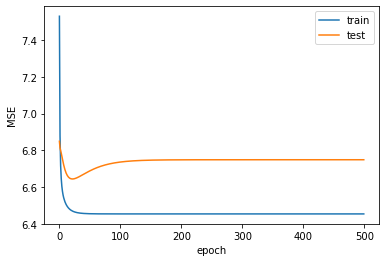

In [17]:
plt.plot([x for x in range(len(train_loss))],train_loss,label='train')
plt.plot([x for x in range(len(test_loss))],test_loss,label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')

In [18]:
test_loss[-1]

[6.748629952975673]